In [2]:
import matplotlib

In [3]:
%matplotlib

Using matplotlib backend: <object object at 0x7f91a5e193b0>


In [ ]:
%matplotlib tk
matplotlib.use('TkAgg')

In [4]:
%matplotlib inline

In [3]:
# %matplotlib qt
# matplotlib.use('TkAgg')
from mpl_interactions import ioff, panhandler, zoom_factory
import matplotlib.pyplot as plt
import pylab as plt
import blimpy
from blimpy import Waterfall
from blimpy import calcload
import os
import glob
import numpy as np
import time
from scipy.stats import norm, kurtosis, kurtosistest
import scipy
import numpy.ma as ma

import sys
file_path = '/lustre/aoc/students/jsofair/playing-with-cosmic-data/filterbank/'
sys.path.insert(1, file_path[:54])
from analysis_functions import plot_tavg_power

In [5]:
file_list = glob.glob(os.path.join(file_path,'*.fil'))

ml_list = []
for i, file in enumerate(file_list):
    ml = blimpy.calcload.calc_max_load(os.path.join(file))
    ml_list.append(ml)
    print(f'{ml} -- {file[65:]}')

11.0 -- band_test_AC_CO-beam0001.fil
9.0 -- Band_Test_BD_C512-beam0001.fil
9.0 -- band_test_AC_C512-beam0001.fil
11.0 -- Band_Test_BD_C0-beam0001.fil
7.0 -- band_test_GPU3_BD_C32-beam0001.fil
11.0 -- band_test_AC_C32-beam0001.fil
4.0 -- band_test_AC_C544-beam0001.fil


In [6]:
t0=time.time()


# water0 = Waterfall(os.path.normpath(file_list[0]), max_load = ml_list[0])
# water1 = Waterfall(os.path.normpath(file_list[1]), max_load = ml_list[1])
# water2 = Waterfall(os.path.normpath(file_list[2]), max_load = ml_list[2])
# water3 = Waterfall(os.path.normpath(file_list[3]), max_load = ml_list[3])
# water4 = Waterfall(os.path.normpath(file_list[4]), max_load = ml_list[4])
water5 = Waterfall(os.path.normpath(file_list[5]), max_load = ml_list[5])
# water6 = Waterfall(os.path.normpath(file_list[6]), max_load = ml_list[6])

# water_list = [water0, water1, water2, water3, water4, water5, water6]
# print(water_list)

t1 = time.time()
print(f'Elapsed time: {t1 - t0}')

Elapsed time: 7.804612636566162


In [37]:
water5.info()
f_min=np.floor(np.amin(water5.get_freqs()))
f_max=np.ceil(np.amax(water5.get_freqs()))
# 640 channels
# ~4.2 M fine frequency channels


--- File Info ---
      machine_id :                                0
    telescope_id :                               -1
         src_raj :                 4:09:22.00873993
         src_dej :                12:17:39.84749624
        az_start :             6.9397794901351e-310
        za_start :             4.6720091597949e-310
       data_type :                                1
            fch1 :           2028.4999961853027 MHz
            foff :           -7.62939453125e-06 MHz
          nchans :                          4194304
          nbeams :                                2
           ibeam :                                1
           nbits :                               32
   tstart (ISOT) :          2023-05-10T21:56:53.857
    tstart (MJD) :                60074.91451223567
           tsamp :                         0.131072
            nifs :                                1
     barycentric :                                1
   pulsarcentric :                           

In [147]:
def get_tavg_kurtosis(wf_in, n_divs=128):
    # This function grabs the kurtosis of channels of a specified size for a blimpy waterfall object
    
    # wf_in: Specified blimpy waterfall object
    # n_divs: Number of divisions to break wf_in into
        # 32 is the correct number of channels to break a waterfall into assuming the frequency range
        # of the waterfall is 32 MHz
        
    np.set_printoptions(threshold=4)

    # Get power and frequency in increasing order
    if wf_in.header['foff'] < 0:
        pows_flipped = np.flip(wf_in.data)
        freqs_flipped = wf_in.get_freqs()[::-1]
    
    # Time-average the power
    pows_mean_flipped = np.mean(pows_flipped, axis=0)[0]    

    # Split frequency and time-averaged power into n_divs channels
    freqs = np.array_split(freqs_flipped, n_divs)
    pows_mean = np.array_split(pows_mean_flipped, n_divs)
    
    # Get kurtosis of all channels
    kurts_list = []
    
    for i, division in enumerate(pows_mean):
        kurts_list.append(kurtosis(division/(10**9))) # Rescaling data so that kurtosis != inf ever

    kurts = np.array(kurts_list, dtype=np.float64)
    
    # Binning frequencies such that the labeled frequency is the bottom of the bin
    # i.e., if chnl[0] is 2010 MHz and each channel is 1 MHz, then the bin from 2010 MHz to 2010.99 MHz will have
    # a value of "2010"
    bins = []
    for chnl in freqs:
        bins.append(chnl[0])

    # bins: All frequency bins for the frequency range of the waterfall
    # kurts: Kurtosis of all frequency bins
        
    return bins, kurts

In [148]:
def plot_tavg_kurtosis(wf_in, n_divs=128):
    # This function plots the kurtosis of the time-averaged power spectrum.
    # For info on inputs, see get_tavg_kurtosis() function definition.
    
    # Get bin and kurtosis information
    bins, kurts = get_tavg_kurtosis(wf_in, n_divs)
    
    # Plot kurtosis vs. frequency
    fig, ax = plt.subplots()
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Kurtosis')
    
    ax.plot(bins, kurts, '.')

In [175]:
def get_mask_kurtosis(wf_in, n_divs=128, threshold=50):
    # This function flags bins with high kurtosis (i.e., heavy RFI) and returns the necessary information about
    # these bins.
    # wf_in: See get_tavg_kurtosis() function definition
    # n_divs: See get_tavg_kurtosis() function definition
    # threshold: Minimum kurtosis for a channel to be flagged as 'RFI-heavy'
    
    # Get bin and kurtosis information
    bins, kurts = get_tavg_kurtosis(wf_in, n_divs)
    
    # TODO: Is it true that the abs of the kurtosis is being taken?
    # masked_kurts is an array that has all channels with |kurtosis| > threshold masked
    masked_kurts = ma.masked_where(np.abs(kurts) > threshold, kurts)
    mask = ma.getmask(masked_kurts)
    
    
#     print(f'{mask}')
    # flagged_bins is an array that has the frequencies of the channels with kurtosis > threshold
    # flagged_kurts masks the opposite elements as masked_kurts
    flagged_bins = ma.masked_array(bins, mask=~mask)
    flagged_kurts = ma.masked_array(kurts, mask=~mask)

    print(f'{ma.count(flagged_bins)} out of {n_divs} channels flagged as having substantial RFI')

    
    # Summary of returned variables:
    # flagged_bins: Channels with high kurtosis (i.e., high RFI)
    # flagged_kurts: Kurtosis of each channel that was flagged as having high RFI
    # masked_kurts: Kurtosis of all 'clean' (low RFI) channels with high RFI channels masked out
    # mask: The mask used to generate masked_kurts
    return flagged_bins, flagged_kurts, masked_kurts, mask

In [150]:
array = [-2,-1,0,1,2]
print(ma.masked_greater(np.abs(array), 1))

[-- 1 0 1 --]


In [181]:
def plot_mask_kurtosis(wf_in, n_divs=128, threshold=50, unfiltered=True, clean_chnls=True, rfi=False,
                      f_start=0, f_stop=0, k_start=0, k_stop=0):
    # This function plots the kurtosis of each frequency channel for a specified waterfall object.
    # wf_in: See get_tavg_kurtosis() function definition
    # n_divs: See get_tavg_kurtosis() function definition
    # threshold: See get_mask_kurtosis() function definition
    # unfiltered: If true, plot the data before any RFI filtering has occurred
    # clean_chnls: If true, plot the data after RFI has been filtered out
    # rfi: If true, plot the channels that have been marked as RFI
    
    bins, kurts = get_tavg_kurtosis(wf_in, n_divs)
    flagged_bins, flagged_kurts, masked_kurts, mask = get_mask_kurtosis(wf_in, n_divs, threshold)
    
    fig, ax = plt.subplots()
    
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Kurtosis')
    
    if unfiltered:
        ax.plot(bins, kurts, 'o', c='#4287f5', label='Unfiltered data') # Color is a nice blue
    if clean_chnls:
        ax.plot(bins, masked_kurts, '.', c='#43cc5c', label='Clean channels') # Color is a nice green
    if rfi:
        ax.plot(flagged_bins, flagged_kurts, '.', c='red', label='Heavy RFI') # Color is red
    
    if np.any([f_start, f_stop, k_start, k_stop]) != 0:
        ax.set_xlim(f_start, f_stop)
        ax.set_ylim(k_start, k_stop)
    
        ax.legend(fancybox=True,shadow=True, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=3)
    else:
        ax.legend(fancybox=True,shadow=True, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=3)

In [185]:
def plot_tavg_powertemp(wf_in,
                    f_start=0, f_stop=6000,
                    p_start=0, p_stop=5*10**10, n_divs=128, threshold=50, show_filtered=True):
    # Plot the time-averaged power spectrum for a given blimpy waterfall object
    # wf: The desired input waterfall object
    # t: The integration number
    # f_start: Lower bound for frequency (horizontal) axis
    # f_stop: Upper bound for frequency (horizontal) axis
    # p_start: Lower bound for time-averaged power (veritcal) axis
    # p_start: Lower bound for time-averaged power (veritcal) axis

    # Time average the power
    wf_pwr_mean = np.mean(wf_in.data, axis=0)
    wf_pwr_mean_integration = wf_pwr_mean[0]
   
    # Plot time-averaged power
#     with plt.ioff():
    fig, ax = plt.subplots()
    
    ax.set_xlim(f_start, f_stop)
    ax.set_ylim(p_start, p_stop)
    
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Time-Averaged Power (Counts)')

    ax.plot(wf_in.get_freqs(), wf_pwr_mean_integration, label='Time-averaged power spectrum')

    # Grab info for RFI masking
    bins, kurts = get_tavg_kurtosis(wf_in, n_divs)
    flagged_bins, flagged_kurts, masked_kurts, mask = get_mask_kurtosis(wf_in, n_divs, threshold)

    # Plot frequency bins that were flagged as RFI
    if show_filtered == True:
        full_freq_range = np.amax(wf_in.get_freqs()) - np.amin(wf_in.get_freqs())

        bin_width = full_freq_range / n_divs

        for rfi_bin in flagged_bins:
            xmin = rfi_bin
            xmax = rfi_bin + bin_width
            flagged_line = plt.axvspan(xmin=xmin, xmax=xmax, ymin=0, ymax=1, color='red', alpha=0.4,mouseover=True)

        flagged_line.set_label('RFI-flagged channels')   
    
        ax.legend(fancybox=True,shadow=True, loc='lower center', bbox_to_anchor=(1, 1), ncols=1)
    else:
        ax.legend(fancybox=True,shadow=True, loc='lower center', bbox_to_anchor=(1, 1), ncols=1)

#     disconnect_zoom = zoom_factory(ax)
#     pan_handler = panhandler(fig)
#     display(fig.canvas)

150 out of 256 channels flagged as having substantial RFI


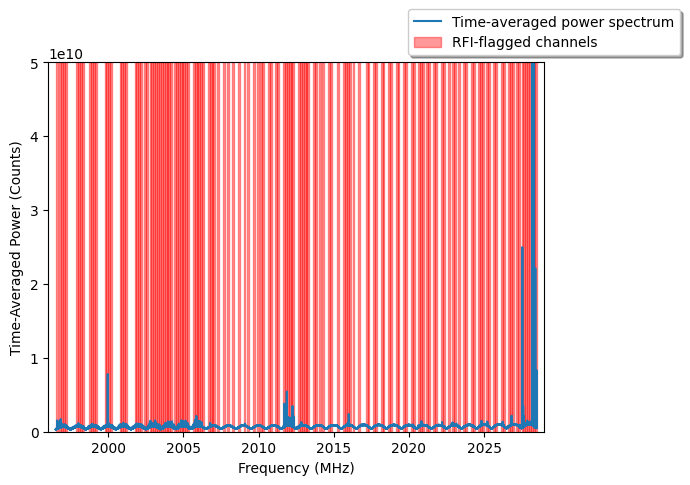

In [187]:
plot_tavg_powertemp(water5, f_start=f_min, f_stop=f_max,  n_divs=256, threshold=1, show_filtered=True)

In [ ]:
bins, kurts = get_tavg_kurtosis(water5, n_divs=256)
for i in bins:
    print(i)
    

In [176]:
bins, kurts = get_tavg_kurtosis(water5, n_divs=256)
flagged_bins, flagged_kurts, masked_kurts, mask = get_mask_kurtosis(water5, n_divs=256, threshold=1)

rfi_flagged_bins = []
clean_bins = []

for i in ma.nonzero(flagged_kurts)[0]:
    rfi_flagged_bins.append(flagged_kurts[i])

# print(masked_kurts[ma.nonzero(masked_kurts)[0][0]])
# print(ma.nonzero(masked_kurts)[0])
for j in ma.nonzero(masked_kurts)[0]:
    clean_bins.append(masked_kurts[j])

np.set_printoptions(threshold=sys.maxsize, suppress=True)
print(f'rfi bins ({len(rfi_flagged_bins)}): {np.sort(rfi_flagged_bins)}\n\nClean bins ({len(clean_bins)}): {np.sort(clean_bins)}\n\nAll bins ({len(kurts)}): {np.sort(kurts)}')

150 out of 256 channels flagged as having substantial RFI
rfi bins (150): [   -1.22537625    -1.22523061    -1.22501187    -1.22371716
    -1.22292061    -1.22289406    -1.22219723    -1.22215949
    -1.222023      -1.2217731     -1.22150212    -1.22077957
    -1.22052721    -1.22015753    -1.22003332    -1.21942068
    -1.21849839    -1.21793409    -1.21789249    -1.2176773
    -1.21719218    -1.21677221    -1.21635099    -1.21633154
    -1.21570996    -1.21508725    -1.21484175    -1.21458313
    -1.21426582    -1.21425026    -1.21205181    -1.21185179
    -1.21151147    -1.21124548    -1.2103928     -1.20977439
    -1.20912376    -1.20717942    -1.19599863    -1.19186822
    -1.18630718    -1.05166305    -1.03221387    -1.02851976
    -1.02755517    -1.02686273    -1.02657485    -1.01648999
    -1.01559337    -1.01548566    -1.01511576    -1.01485091
    -1.01451113    -1.01264632    -1.01162207    -1.01136699
    -1.01130502    -1.01050815    -1.00349867    -1.00110573
    -1.00057

150 out of 256 channels flagged as having substantial RFI


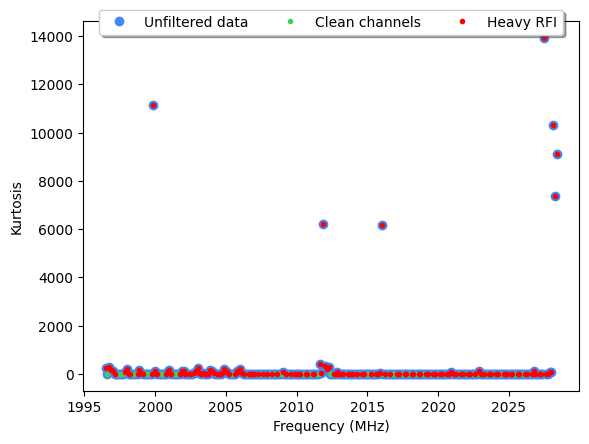

In [183]:
plot_mask_kurtosis(water5, n_divs=256, threshold=1, unfiltered=True, clean_chnls=True, rfi=True)

150 out of 256 channels flagged as having substantial RFI


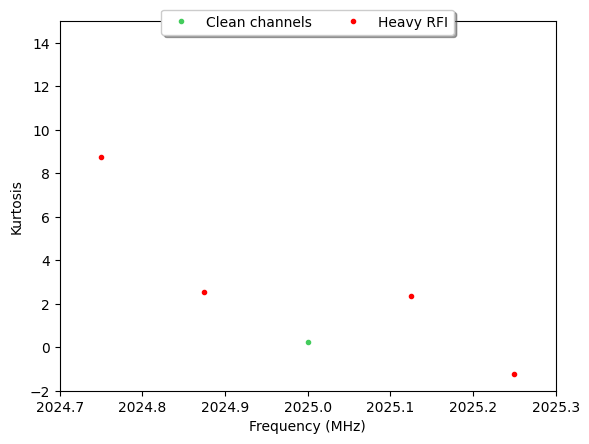

In [184]:
plot_mask_kurtosis(water5, n_divs=256, threshold=1, unfiltered=False, clean_chnls=True, rfi=True,
                  f_start=2024.70, f_stop=2025.3, k_start=-2, k_stop=15)

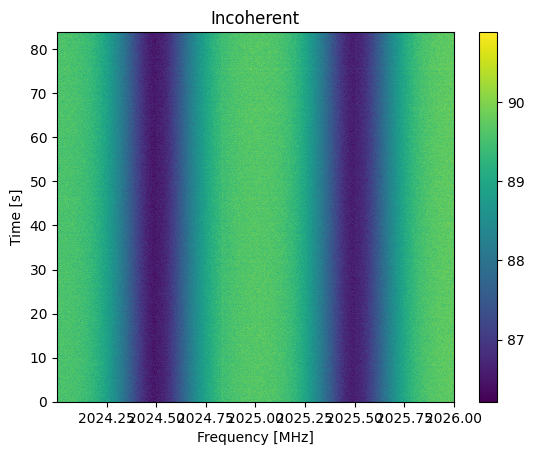

In [86]:
water5.plot_waterfall(f_start=2024, f_stop=2026)

In [168]:
plt.close('all')

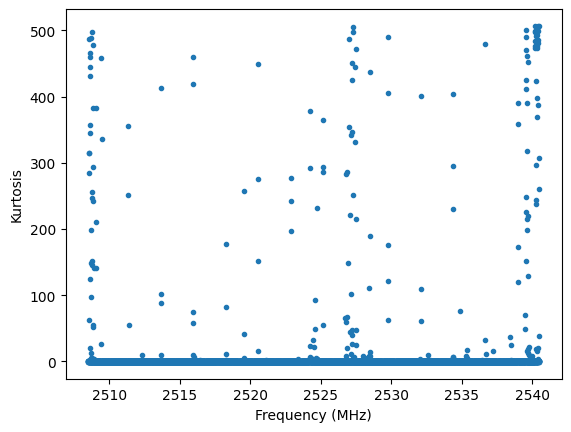

In [49]:
plot_tavg_kurtosis(water5, 8192)

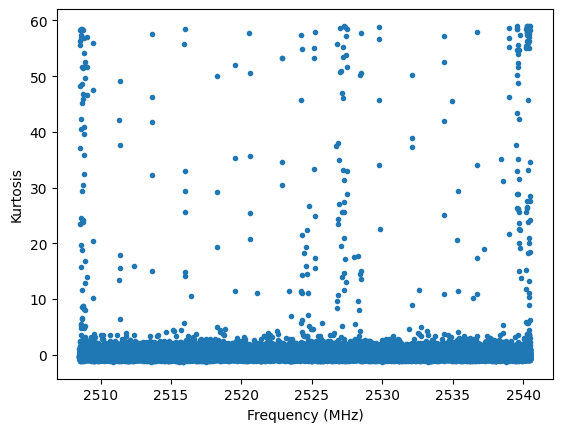

In [43]:
# kurts1 = plot_tavg_kurtosis(water6, 8192)
kurts2 = plot_tavg_kurtosis(water6, 2**16)

Where is kurtosis non-finite: (1, 40), (array([  29,   37,   43, ..., 8186, 8188, 8190]),)
Non-scaled kurtosis length: (1, 8152)
Scaled kurtosis length: (8192,)
Infinite kurtosis length: (1, 40)


(array([ 0.04330681, -0.00755788, -0.22072963, ...,  0.39160954,
                inf,  0.18960121]),
 (array([  29,   37,   43, ..., 8186, 8188, 8190]),))

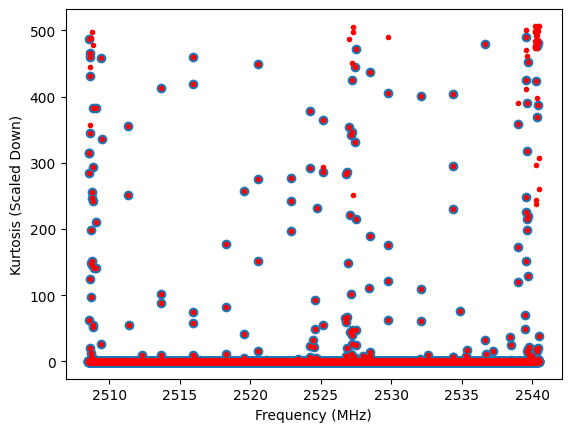

In [40]:
plot_tavg_kurtosis_scale(water6, 8192)

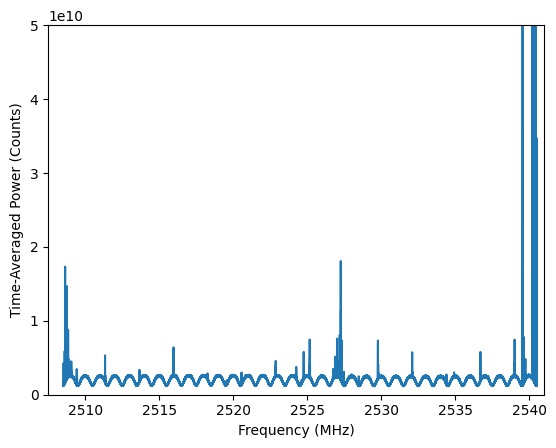

In [12]:
plot_tavg_power(water6, f_start=2507.5, f_stop=2541, find_inf=False, n_divs=8192)

In [8]:
t0 = time.time()
n_divs = 32
all_sig_kurts = []
all_sig_freqs = []
pltdata = []

wf_n = np.array_split(water6.get_freqs(), n_divs) # Split wf into (n_divs) divisions
for division in wf_n:
    f_start = np.amin(division)
    f_stop = np.amax(division)
    
    plot_f, plot_data = water6.grab_data(f_start, f_stop, if_id=0)
    
    # Using accending frequency for all plots.
    if water6.header['foff'] < 0:
            plot_data = plot_data[..., ::-1]  # Reverse data
            plot_f = plot_f[::-1]
            
    print(type(plot_data))
    print(np.shape(plot_data))
    
    pltdata.append(kurtosis(plot_data, axis=0, nan_policy='omit'))
    try:
        print(np.shape(pltdata))
    except:
#         print(np.shape(pltdata))
        print("The shape of pltdata is now inhomogeneous")
    
    # Add kurtoses with Pearson kurt() > 0 to an array
#     all_sig_kurts.append(pltdata[np.where(pltdata[0] > 0)])
    
    # Make sure you use plot_f and NOT wf.get_freqs() because the order of wf.get_freqs() is decreasing,
    # but we want it to be increasing!
    
    # Add frequencies with Pearson kurt() > 0 to an array
#     all_sig_freqs.append(plot_f[np.where(pltdata[0] > 0)])
    
t1 = time.time()
print(f'Elapsed time: {t1 - t0}')

<class 'numpy.ndarray'>
(223, 131072)
(1, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(2, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(3, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(4, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(5, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(6, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(7, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(8, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(9, 131072)
<class 'numpy.ndarray'>
(223, 131072)


KeyboardInterrupt: 

In [ ]:
# fig, ax = plt.subplots()

# ax.plot()

In [12]:
plt.close('all')